# `Module 5`: Introduction to Convolutional NN

### Problem Statement:

* The task at hand involves classifying images of cats and dogs using a Convolutional Neural Network (CNN). We have a dataset containing images of cats and dogs and the objective is to train a CNN model to accurately predict the class of each image.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
random_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [ ]:
dataset = datasets.ImageFolder(root='dataset/cat_dog_dataset', transform=random_transforms)

In [5]:
len(dataset)

10028

In [6]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size])

In [7]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [8]:
# check data
sample = iter(train_loader)
img, lab = next(sample)
img.shape

torch.Size([32, 3, 128, 128])

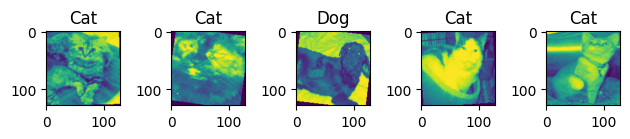

In [9]:
for i in range(5):
    label = ["Dog" if lab[i] == 1 else "Cat"]
    plt.subplot(1, 5, i+1)
    plt.imshow(img[i][0])
    plt.title(label[0])
    plt.tight_layout()

In [10]:
# CNN Model Architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 128-3+2/1+1 = 128/2 = 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64-3+2/1+1 = 64/2 = 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # x/2
        self.fc1 = nn.Linear(64*32*32, 128) 
        self.fc2 = nn.Linear(128, 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [11]:
model = CNNModel().to(device)

In [12]:
lr = 0.01
epoch_size = 10

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [14]:
# train the model
model.train()
for epoch in range(epoch_size):
    total_loss = 0
    for train_img, train_lab in train_loader:
        train_img, train_lab = train_img.to(device), train_lab.to(device)
        pred_train_lab = model(train_img)

        optimizer.zero_grad()
        loss = criterion(pred_train_lab, train_lab)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"epoch: {epoch+1}/{epoch_size} loss: {total_loss:0.4f}")

epoch: 1/10 loss: 168.3736
epoch: 2/10 loss: 154.6518
epoch: 3/10 loss: 144.3276
epoch: 4/10 loss: 138.7024
epoch: 5/10 loss: 130.9100
epoch: 6/10 loss: 125.2520
epoch: 7/10 loss: 121.8617
epoch: 8/10 loss: 114.4581
epoch: 9/10 loss: 110.8676
epoch: 10/10 loss: 107.8444


In [16]:
# model Evalution
model.eval()
with torch.no_grad():
    total_correct = 0
    total = 0
    for test_img, test_lab in test_loader:
        test_img, test_lab = test_img.to(device), test_lab.to(device)

        output = model(test_img)
        pred_test_lab = torch.argmax(output, dim=1)

        total_correct += (pred_test_lab == test_lab).sum().item()
        total += test_img.size(0)
    
    print(f"Model Accuracy is {total_correct/total*100:0.2f}%")

Model Accuracy is 79.06%


In [32]:
# prdiction function
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = random_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        predicted = torch.argmax(output, dim=1)
    return "Cat" if predicted.item() == 0 else "Dog"

In [33]:
print(predict_image("test_img_cat.png"))

Cat
